# Extracción de Entidades Nombradas con CRF

En esta práctica, implementaremos un sistema de reconocimiento de entidades nombradas utilizando Conditional Random Fields (CRF). Utilizaremos el corpus CONLL2002 que contiene textos en español y holandés, con anotaciones para cuatro tipos de entidades: LOC (ubicaciones), MISC (miscelánea), ORG (organizaciones), y PER (personas).

Seguiremos un enfoque incremental:
1. Exploraremos el dataset y su estructura
2. Definiremos diferentes conjuntos de características (features)
3. Entrenaremos modelos CRF con diferentes configuraciones
4. Evaluaremos el rendimiento utilizando diversas métricas
5. Optimizaremos nuestro modelo mediante experimentación

## 1. Configuración Inicial

Primero, importaremos las bibliotecas necesarias y cargaremos los datos básicos. Importamos los archivos locations.txt y person_names.txt para posteriormente tratar los gazzetters, estos contienen listados de nombres en castellano y holandés de personas y de todos los paises y buena parte de las ciudades del mundo.

In [51]:
import re
import nltk
import pandas as pd
from nltk.corpus import conll2002
from nltk.tag import CRFTagger
from sklearn.metrics import classification_report
from typing import List, Dict, Tuple
from sklearn.metrics import balanced_accuracy_score

# Descarrega les dades necessàries
nltk.download('conll2002')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Carrega els gazetteers (llistes d'entitats conegudes)
with open("locations.txt", encoding="utf-8") as f:
    locations_set = set(line.strip().lower() for line in f if line.strip())
    print(f"Carregades {len(locations_set)} ubicacions al gazetteer")

with open("person_names.txt", encoding="utf-8") as f:
    person_names_set = set(line.strip().lower() for line in f if line.strip())
    print(f"Carregats {len(person_names_set)} noms al gazetteer")

Carregades 106150 ubicacions al gazetteer
Carregats 123466 noms al gazetteer


[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11ser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Carrega de dades i exploració inicial

En primer lloc, vam importar les dades d'entrenament, validació i test de cada un dels dos idiomes. Aquestes dades venien en la codificació "BIO". Més endavant aquests tags es tractarien per provar altres codificacions.

In [40]:
# Carrega de conjunts de dades en català (espanyol)
esp_train = list(conll2002.iob_sents('esp.train'))
esp_dev = list(conll2002.iob_sents('esp.testa'))
esp_test = list(conll2002.iob_sents('esp.testb'))

# Carrega de conjunts de dades en neerlandès
ned_train = list(conll2002.iob_sents('ned.train'))
ned_dev = list(conll2002.iob_sents('ned.testa'))
ned_test = list(conll2002.iob_sents('ned.testb'))

# Mostrar informació sobre els conjunts de dades
print(f"Espanyol - Train: {len(esp_train)} oracions, Dev: {len(esp_dev)} oracions, Test: {len(esp_test)} oracions")
print(f"Neerlandès - Train: {len(ned_train)} oracions, Dev: {len(ned_dev)} oracions, Test: {len(ned_test)} oracions")

# Veure un exemple d'oració
print("\nExemple d'oració en espanyol:")
print(esp_train[0])

# Analitzar la distribució d'etiquetes
def count_tags(dataset):
    tag_counts = {}
    for sent in dataset:
        for _, _, tag in sent:
            tag_counts[tag] = tag_counts.get(tag, 0) + 1
    return tag_counts

esp_tags = count_tags(esp_train)
print("\nDistribució d'etiquetes en espanyol (train):")
for tag, count in sorted(esp_tags.items(), key=lambda x: x[1], reverse=True):
    print(f"{tag}: {count}")

Espanyol - Train: 8323 oracions, Dev: 1915 oracions, Test: 1517 oracions
Neerlandès - Train: 15806 oracions, Dev: 2895 oracions, Test: 5195 oracions

Exemple d'oració en espanyol:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Distribució d'etiquetes en espanyol (train):
O: 231920
B-ORG: 7390
I-ORG: 4992
B-LOC: 4913
B-PER: 4321
I-PER: 3903
I-MISC: 3212
B-MISC: 2173
I-LOC: 1891


## Classe per al maneig de dades

Per al maneig adequat de les dades, vam implementar una classe anomenada `NERDataProcessor` que facilita la càrrega i transformació de les dades. Aquesta classe està dissenyada per ser flexible en quant a l'idioma utilitzat, permetent-nos treballar tant amb dades en espanyol com en holandès.

La classe s'inicialitza amb un paràmetre d'idioma que per defecte és "spanish", però que també pot ser "dutch". Aquest paràmetre determina quins conjunts de dades es carregaran.

El primer mètode important és ``load_data``, el qual s'encarrega de carregar els conjunts de dades d'entrenament, desenvolupament i test segons l'idioma especificat. Si l'idioma és espanyol, carrega els fitxers 'esp.train', 'esp.testa' i 'esp.testb'. Si és holandès, carrega 'ned.train', 'ned.testa' i 'ned.testb'. Tots aquests fitxers es carreguen utilitzant la funció ``iob_sents`` del corpus conll2002 de NLTK.

El segon mètode, ``convert_to_features``, pren les dades en format [(paraula, pos, etiqueta), ...] i les converteix en característiques que poden ser utilitzades pel model, retornant només les paraules i les seves etiquetes POS: [(paraula, pos), ...]. Aquest mètode és essencial perquè separa les característiques de les etiquetes que volem predir.

Finalment, el mètode ``get_labels`` extreu només les etiquetes de les dades, creant llistes d'etiquetes [etiqueta, ...] per cada oració. Aquestes etiquetes són les que el model intentarà predir durant l'entrenament i avaluació.

Aquesta classe ens va permetre estructurar millor el nostre codi i mantenir una clara separació entre les dades, les seves característiques i les etiquetes, facilitant així el procés d'experimentació amb diferents configuracions del model.

In [52]:
class NERDataProcessor:
    def __init__(self, language: str = "spanish"):
        # Inicialitza el processador de dades NER per idioma
        self.language = language
        
    def load_data(self):
        # Carrega els conjunts de dades train, dev i test segons l'idioma
        if self.language == "spanish":
            return (
                conll2002.iob_sents('esp.train'),
                conll2002.iob_sents('esp.testa'),
                conll2002.iob_sents('esp.testb')
            )
        return (
            conll2002.iob_sents('ned.train'),
            conll2002.iob_sents('ned.testa'),
            conll2002.iob_sents('ned.testb')
        )
    
    def convert_to_features(self, data):
        # Converteix les dades a format de característiques (paraula, POS)
        return [[(word, pos) for word, pos, _ in sent] for sent in data]

    def get_labels(self, data):
        # Extreu les etiquetes de les dades
        return [[tag for _, _, tag in sent] for sent in data]


### Demostració del processador de dades

Per entendre millor el funcionament del nostre processador de dades `NERDataProcessor`, a continuació es mostra un exemple d'ús per a l'idioma espanyol:


In [53]:
# Instanciar el processador per a català (espanyol)
processor_es = NERDataProcessor("spanish")

# Carregar les dades
train, dev, test = processor_es.load_data()

# Convertir a característiques i etiquetes
X_train = processor_es.convert_to_features(train)
y_train = processor_es.get_labels(train)

print(f"Nombre d'oracions al train: {len(X_train)}")
print(f"Exemple de característiques per a una oració:")
print(X_train[0][:5])  # Primers 5 tokens de la primera oració
print(f"Exemple d'etiquetes per a la mateixa oració:")
print(y_train[0][:5])  # Etiquetes corresponents

Nombre d'oracions al train: 8323
Exemple de característiques per a una oració:
[('Melbourne', 'NP'), ('(', 'Fpa'), ('Australia', 'NP'), (')', 'Fpt'), (',', 'Fc')]
Exemple d'etiquetes per a la mateixa oració:
['B-LOC', 'O', 'B-LOC', 'O', 'O']


## Generador de característiques per al CRF

Per tal de millorar el rendiment del model CRF, vam implementar una classe especialitzada anomenada `CRFFeatureGenerator` que permet generar de manera flexible diferents conjunts de característiques per a cada token.

Aquesta classe es configura a través d'un diccionari que permet activar o desactivar diferents grups de característiques, facilitant així l'experimentació amb diverses combinacions sense necessitat de modificar el codi base.

La funció principal `get_features()` rep una llista de tokens d'una oració i l'índex del token actual, i retorna una llista de característiques per a aquest token específic. Les característiques es generen segons els següents grups:

### Característiques bàsiques
- Un valor de "bias" sempre present com a base per al model
- Forma de la paraula (la paraula original i la seva versió en minúscules)

### Característiques de POS i lematització
- L'etiqueta POS (Part-of-Speech) del token
- La forma lematitzada de la paraula, obtinguda mitjançant WordNetLemmatizer

### Característiques morfològiques
- Si la paraula comença amb majúscula
- Si la paraula està completament en majúscules
- Si la paraula només conté dígits
- Si la paraula conté algun dígit
- Si la paraula conté símbols no alfanumèrics

### Prefixos i sufixos
- Prefixos de la paraula fins a 3 caràcters (si la longitud ho permet)
- Sufixos de la paraula fins a 3 caràcters (si la longitud ho permet)

### Longitud de la paraula
- La longitud en caràcters de la paraula

### Posició en l'oració
- L'índex del token en l'oració
- Si és el primer token de l'oració
- Si és l'últim token de l'oració

### Context circumdant
- Característiques de la paraula anterior (si existeix): forma en minúscules, si comença amb majúscula, si és un número, i la seva etiqueta POS
- Característiques de la paraula següent (si existeix): forma en minúscules, si comença amb majúscula, si és un número, i la seva etiqueta POS
- Marcadors especials per a l'inici i el final de l'oració

### Característiques de gazetteers
- Si la paraula apareix en una llista predefinida de localitzacions
- Si la paraula apareix en una llista predefinida de noms de persona

Aquesta implementació ens va permetre experimentar amb diferents combinacions de característiques, observant el seu impacte en el rendiment del model i seleccionant les més efectives per a la tasca de reconeixement d'entitats anomenades.

In [54]:
class CRFFeatureGenerator:
    def __init__(self, feature_config: Dict):
        #feature_config: Diccionari de configuració amb banderes per activar/desactivar grups de característiques
        self.config = feature_config
        self.lemmatizer = nltk.WordNetLemmatizer()
        
    def get_features(self, tokens: List[Tuple[str, str]], index: int) -> List[str]:
        """
        Genera característiques per a un token en una posició específica.
        
        Args:
            tokens: Llista de tokens de l'oració [(paraula, pos), ...]
            index: Índex del token actual
            
        Returns:
            Llista de característiques per al token
        """
        word, pos = tokens[index]
        features = ["bias"]  # Característica base sempre present
        
        # --- Característiques de la paraula ---
        if self.config.get("word_form", True):
            features.append(f"word={word}")
            features.append(f"word.lower={word.lower()}")

        # --- Característiques de POS i lematització ---
        if self.config.get("pos", True):
            features.append(f"pos={pos}")
            features.append(f"lemma={self.lemmatizer.lemmatize(word.lower())}")

        # --- Característiques morfològiques ---
        if self.config.get("morphology", True):
            features.append(f"is_title={word.istitle()}")
            features.append(f"is_upper={word.isupper()}")
            features.append(f"is_digit={word.isdigit()}")
            features.append(f"has_digit={any(c.isdigit() for c in word)}")
            features.append(f"has_symbol={not word.isalnum()}")

        # --- Prefixos i sufixos ---
        if self.config.get("prefix_suffix", True):
            if len(word) >= 3:
                features.append(f"prefix3={word[:3]}")
                features.append(f"suffix3={word[-3:]}")
            if len(word) >= 2:
                features.append(f"prefix2={word[:2]}")
                features.append(f"suffix2={word[-2:]}")

        # --- Longitud de la paraula ---
        if self.config.get("length", True):
            features.append(f"length={len(word)}")

        # --- Posició a l'oració ---
        if self.config.get("position", True):
            features.append(f"position={index}")
            features.append(f"is_first={index == 0}")
            features.append(f"is_last={index == len(tokens)-1}")

        # --- Context circumdant ---
        if self.config.get("context", True):
            # Paraula anterior
            if index > 0:
                prev_word, prev_pos = tokens[index-1]
                features.append(f"prev_word.lower={prev_word.lower()}")
                features.append(f"prev_word.istitle={prev_word.istitle()}")
                features.append(f"prev_word.isdigit={prev_word.isdigit()}")
                features.append(f"prev_pos={prev_pos}")
            else:
                features.append("BOS")  # Inici de l'oració
                
            # Paraula següent
            if index < len(tokens)-1:
                next_word, next_pos = tokens[index+1]
                features.append(f"next_word.lower={next_word.lower()}")
                features.append(f"next_word.istitle={next_word.istitle()}")
                features.append(f"next_word.isdigit={next_word.isdigit()}")
                features.append(f"next_pos={next_pos}")
            else:
                features.append("EOS")  # Final de l'oració

        # --- Característiques de gazetteers ---
        if self.config.get("gazetteers", True):
            features.append(f"in_location_gazetteer={word.lower() in locations_set}")
            features.append(f"in_person_gazetteer={word.lower() in person_names_set}")

        return features

### Demonstració del generador de característiques
La cel·la de codi que es mostra realitza una demostració pràctica del nostre generador de característiques ``CRFFeatureGenerator``, il·lustrant com genera característiques per a un token específic dins d'una oració.

In [55]:
# Configuració completa de característiques
full_config = {
    "word_form": True,
    "pos": True,
    "morphology": True,
    "prefix_suffix": True,
    "length": True,
    "position": True,
    "context": True,
    "gazetteers": True,
}

# Crear generador de característiques
full_feature_gen = CRFFeatureGenerator(full_config)
# Exemple d'oració
example_tokens = X_train[0]
example_word_index = 0  # Índex d'exemple

print("Paraula d'exemple:", example_tokens[example_word_index][0])

# Generar característiques amb la configuració completa
full_features = full_feature_gen.get_features(example_tokens, example_word_index)

print("\nCaracterístiques completes:")
for feat in full_features[:15]:
    print(f"  - {feat}")

print(f"\nTotal de característiques completes: {len(full_features)}")

Paraula d'exemple: Melbourne

Característiques completes:
  - bias
  - word=Melbourne
  - word.lower=melbourne
  - pos=NP
  - lemma=melbourne
  - is_title=True
  - is_upper=False
  - is_digit=False
  - has_digit=False
  - has_symbol=False
  - prefix3=Mel
  - suffix3=rne
  - prefix2=Me
  - suffix2=ne
  - length=9

Total de característiques completes: 25


## 4. Modelo CRF y Entrenamiento

Ahora implementaremos la clase `CRFModel` que encapsula la lógica de entrenamiento y predicción con CRF.

In [ ]:
class CRFModel:
    def __init__(self, feature_generator: CRFFeatureGenerator):
        # Inicialitza el model CRF amb el generador de característiques
        self.ct = CRFTagger(feature_func=feature_generator.get_features)
        
    def train(self, train_sents, train_labels, model_file='model.crf'):
        # Entrena el model CRF amb les dades d'entrenament
        formatted_data = self._format_data(train_sents, train_labels)
        self.ct.train(formatted_data, model_file)
        
    def predict(self, test_sents):
        # Preveu etiquetes per a les oracions donades
        tagged_sents = self.ct.tag_sents(test_sents)
        return [[tag for _, tag in sent] for sent in tagged_sents]
        
    def _format_data(self, sents, labels):
        # Dona format a les dades per entrenar el CRFTagger
        return [list(zip(sent, label)) for sent, label in zip(sents, labels)]


### Funcions d'Avaluació

Per avaluar eficaçment els nostres models de reconeixement d'entitats anomenades, vam implementar dues funcions clau que permeten treballar amb qualsevol esquema de codificació (BIO, IO, BIOE, BIOS, BIOES) el qual és transformat a IO a l'hora d'avaluar-se per tal de mantenir consistència.

#### Extracció d'Entitats

La funció `entity_finder` resol un dels principals reptes en l'avaluació de NER: detectar correctament entitats completes independentment de l'esquema d'etiquetatge utilitzat. Aquesta funció processa etiquetes de diferents formats i extreu les entitats com a tuples que contenen el tipus d'entitat i les seves posicions d'inici i final.

L'algorisme implementat segueix un enfocament de màquina d'estats que:

1. Fa un seguiment de l'estat actual de cada entitat (si estem dins d'una entitat, el seu tipus i posició inicial)
2. Detecta canvis de tipus d'entitat mentre es manté dins d'una seqüència de tokens
3. Finalitza entitats quan es troba una etiqueta que no forma part d'una entitat
4. Gestiona entitats que apareixen al final d'una oració

Aquesta implementació universal ens permet comparar models que utilitzen diferents esquemes de codificació sense necessitat de convertir manualment les prediccions.

#### Avaluació Integral del Model

La funció `evaluate_model` proporciona una anàlisi completa del rendiment dels nostres models NER mitjançant dos enfocaments complementaris:

1. **Precisió balancejada a nivell de token**: 
   - Converteix les etiquetes a format IO per garantir una comparació justa entre esquemes
   - Compensa el desequilibri entre etiquetes "O" (no-entitat) i etiquetes d'entitat
   - Ens permet valorar la capacitat del model d'identificar la presència d'entitats, independentment del seu tipus

2. **Mètriques a nivell d'entitat completa**:
   - **Percentatge d'entitats detectades perfectament**: Proporció d'entitats reals que s'identifiquen amb la posició exacta i tipus correcte
   - **Mètriques per tipus d'entitat**: Percentatge d'entitats correctament identificades per a cada categoria (LOC, MISC, ORG, PER)
   - **Entitats inventades**: Quantitat de falsos positius (entitats predites que no existeixen)

3. **Mètriques globals**:
   - **Precisió**: Proporció d'entitats identificades que són correctes
   - **Recall**: Proporció d'entitats reals que van ser correctament identificades
   - **F1-Score**: Mitjana harmònica entre precisió i recall

4. **Anàlisi d'errors**: Quan es sol·licita, la funció retorna una llista detallada de prediccions incorrectes, permetent una anàlisi qualitativa dels errors.

Aquesta avaluació integral va més enllà de les mètriques estàndard basades en tokens, centrant-se en la identificació correcta d'entitats completes, que és l'objectiu real dels sistemes NER. A més, considera tant la ubicació com el tipus de cada entitat, oferint una visió més realista del rendiment del model.

Aquestes funcions ens van permetre comparar objectivament diferents configuracions i seleccionar els models òptims per a cada idioma i esquema de codificació, prioritzant la detecció perfecta d'entitats completes.

<!-- ### Funcions d'Avaluació Universal

Per avaluar eficaçment els nostres models de reconeixement d'entitats anomenades, vam implementar dues funcions clau que permeten treballar amb qualsevol esquema de codificació (BIO, IO, BIOE, BIOS, BIOES).

#### Extracció Universal d'Entitats

La funció `entity_finder_universal` resol un dels principals reptes en l'avaluació de NER: detectar correctament entitats completes independentment de l'esquema d'etiquetatge utilitzat. Aquesta funció processa etiquetes de diferents formats i extreu les entitats com a tuples que contenen el tipus d'entitat i les seves posicions d'inici i final.

L'algorisme implementat segueix un enfocament de màquina d'estats que:

1. Fa un seguiment de l'estat actual de cada entitat (si estem dins d'una entitat, el seu tipus i posició inicial)
2. Gestiona correctament les transicions entre diferents prefixos d'etiquetes (B-inici, I-interior, E-final, S-única)
3. Detecta canvis de tipus d'entitat mentre es manté dins d'una seqüència de tokens
4. Finalitza entitats quan es troba una etiqueta que no forma part d'una entitat
5. Gestiona entitats que apareixen al final d'una oració

Aquesta implementació universal ens permet comparar models que utilitzen diferents esquemes de codificació sense necessitat de convertir manualment les prediccions.

#### Avaluació Integral del Model

La funció `evaluate_model` proporciona una anàlisi completa del rendiment dels nostres models NER mitjançant dos enfocaments complementaris:

1. **Precisió balancejada a nivell de token**: 
   - Converteix les etiquetes a format IO per garantir una comparació justa entre esquemes
   - Compensa el desequilibri entre etiquetes "O" (no-entitat) i etiquetes d'entitat
   - Ens permet valorar la capacitat del model d'identificar la presència d'entitats, independentment del seu tipus

2. **Mètriques a nivell d'entitat completa**:
   - **Percentatge d'entitats detectades perfectament**: Proporció d'entitats reals que s'identifiquen amb la posició exacta i tipus correcte
   - **Mètriques per tipus d'entitat**: Percentatge d'entitats correctament identificades per a cada categoria (LOC, MISC, ORG, PER)
   - **Entitats inventades**: Quantitat de falsos positius (entitats predites que no existeixen)

3. **Mètriques globals**:
   - **Precisió**: Proporció d'entitats identificades que són correctes
   - **Recall**: Proporció d'entitats reals que van ser correctament identificades
   - **F1-Score**: Mitjana harmònica entre precisió i recall

4. **Anàlisi d'errors**: Quan es sol·licita, la funció retorna una llista detallada de prediccions incorrectes, permetent una anàlisi qualitativa dels errors.

Aquesta avaluació integral va més enllà de les mètriques estàndard basades en tokens, centrant-se en la identificació correcta d'entitats completes, que és l'objectiu real dels sistemes NER. A més, considera tant la ubicació com el tipus de cada entitat, oferint una visió més realista del rendiment del model.

Aquestes funcions ens van permetre comparar objectivament diferents configuracions i seleccionar els models òptims per a cada idioma i esquema de codificació, prioritzant la detecció perfecta d'entitats completes. -->

In [ ]:
import re
from sklearn.metrics import balanced_accuracy_score

# Conversió d'etiquetes a format IO (per avaluació consistent)
def sent_tags_to_IO(sent_tags):
    return [[re.sub(r'\b[BES]-', 'I-', tag) for tag in sent] for sent in sent_tags]

# Extracció d'entitats completes a partir de les etiquetes IO
def entity_finder(sent_tags):
    entities = []
    for sent in sent_tags:
        sent_entities = []
        current_type, start = None, None
        for i, tag in enumerate(sent):
            if tag.startswith("I-"):
                ent_type = tag[2:]
                if current_type != ent_type:
                    if current_type is not None:
                        sent_entities.append((current_type, (start, i-1)))
                    current_type, start = ent_type, i
            else:
                if current_type is not None:
                    sent_entities.append((current_type, (start, i-1)))
                    current_type, start = None, None
        if current_type is not None:
            sent_entities.append((current_type, (start, len(sent)-1)))
        entities.append(sent_entities)
    return entities

# Funció d'avaluació del model NER
def evaluate_model(y_true, y_pred, errors=False):
    info = {"Balanced accuracy": 0.0, "F1 Score": 0.0, "Precision": 0.0, "Recall": 0.0}
    y_true_io = sent_tags_to_IO(y_true)
    y_pred_io = sent_tags_to_IO(y_pred)
    flatten = lambda tags: [tag for sent in tags for tag in sent]
    info['Balanced accuracy'] = balanced_accuracy_score(flatten(y_true_io), flatten(y_pred_io))

    true_entities = entity_finder(y_true_io)
    pred_entities = entity_finder(y_pred_io)
    types = ['LOC', 'MISC', 'ORG', 'PER']
    counts = dict.fromkeys(types, 0)
    correct_counts = dict.fromkeys(types, 0)
    invented = 0

    # Recompte d'entitats reals i correctes per tipus
    for t, p in zip(true_entities, pred_entities):
        t_set, p_set = set(t), set(p)
        for ent in t: counts[ent[0]] += 1
        for ent in t_set & p_set: correct_counts[ent[0]] += 1
        invented += len(p_set - t_set)

    for ent_type in types:
        total = counts[ent_type]
        correct = correct_counts[ent_type]
        info[f'{ent_type} correct'] = correct / total if total else 0.0

    tp = sum(correct_counts.values())
    fp = invented
    fn = sum(counts.values()) - tp
    info['Precision'] = tp / (tp + fp) if (tp + fp) else 0
    info['Recall'] = tp / (tp + fn) if (tp + fn) else 0
    info['F1 Score'] = 2 * info['Precision'] * info['Recall'] / (info['Precision'] + info['Recall']) if (info['Precision'] + info['Recall']) else 0

    # Retorna també la llista d'errors si es demana
    if errors:
        error_list = [(i, ent) for i, (t, p) in enumerate(zip(true_entities, pred_entities)) for ent in set(p) - set(t)]
        return info, error_list
    return info


### Demostració d'avaluació

Per comprovar l'eficàcia de les nostres funcions d'avaluació, realitzem una prova amb un conjunt de dades significatiu:


In [62]:
# Entrena el model amb la configuració bàsica
feature_gen = CRFFeatureGenerator(full_config)
model = CRFModel(feature_gen)
# Entrena només amb un subconjunt de les dades d'entrenament
model.train(X_train[:1500], y_train[:1500])

# Avalua sobre el conjunt de validació (dev)
processor_es = NERDataProcessor("spanish")
_, dev, _ = processor_es.load_data()
X_dev = processor_es.convert_to_features(dev)
y_dev = processor_es.get_labels(dev)

pred_tags = model.predict(X_dev)
eval_results = evaluate_model(y_dev, pred_tags)
display(pd.DataFrame([eval_results]).T.rename(columns={0: "Resultats de l'avaluació"}))

,Resultats de l'avaluació
Balanced accuracy,0.703458
F1 Score,0.654918
Precision,0.675012
Recall,0.635985
LOC correct,0.735868
MISC correct,0.234234
ORG correct,0.646536
PER correct,0.688013


## Pipeline de Experimentación para NER

La función `run_experiment` implementa un pipeline completo para experimentar con modelos de reconocimiento de entidades nombradas usando CRF. Esta función encapsula todo el flujo de trabajo: desde la carga de datos hasta la evaluación final del modelo.

El proceso se divide en varias etapas clave:

1. **Carga de datos**: Utiliza el `NERDataProcessor` para cargar los conjuntos de datos de entrenamiento, desarrollo y prueba según el idioma especificado.

2. **Muestreo controlado**: Permite limitar el tamaño de los datos para experimentos más rápidos, usando un subconjunto del conjunto de entrenamiento y una proporción aún menor para desarrollo.

3. **Preprocesamiento**: Convierte los datos al formato adecuado, separando las características de entrada (palabras y POS tags) de las etiquetas objetivo.

4. **Configuración del modelo**: Inicializa el generador de características con la configuración especificada y crea un modelo CRF basado en él.

5. **Entrenamiento y predicción**: Entrena el modelo con los datos de entrenamiento y genera predicciones sobre el conjunto de desarrollo.

6. **Evaluación**: Calcula métricas de rendimiento detalladas utilizando la función `evaluate_model`, que analiza tanto la precisión a nivel de token como la correcta identificación de entidades completas.

Esta función es fundamental para la experimentación sistemática con diferentes configuraciones de características y permite comparar objetivamente su impacto en el rendimiento del modelo.

In [ ]:
def run_experiment(config: Dict, language: str = "spanish", sample_size=None):
    # Processador de dades segons idioma
    processor = NERDataProcessor(language)
    train, dev, _ = processor.load_data()

    # Limita la mida de la mostra si cal
    if sample_size:
        train = list(train)[:sample_size]
        dev = list(dev)[:sample_size // 10]

    # Converteix dades a característiques i etiquetes
    X_train = processor.convert_to_features(train)
    y_train = processor.get_labels(train)
    X_dev = processor.convert_to_features(dev)
    y_dev = processor.get_labels(dev)

    # Configura i entrena el model
    feature_gen = CRFFeatureGenerator(config)
    model = CRFModel(feature_gen)
    model.train(X_train, y_train)
    y_pred = model.predict(X_dev)

    # Avalua el model
    results = evaluate_model(y_dev, y_pred)
    return results


## Anàlisi sistemàtic de la contribució de les característiques

Després de desenvolupar les nostres funcions d'avaluació, era necessari determinar quines característiques contribuïen realment a millorar el rendiment del model NER. Per això vam implementar un estudi d'ablació sistemàtic que ens permet analitzar l'impacte individual i combinat de cada grup de característiques.

La funció `feature_ablation_study` automatitza aquest procés mitjançant quatre estratègies complementàries:

1. **Avaluació de la configuració base**: Analitzem el rendiment utilitzant només la característica més bàsica (forma de la paraula)

2. **Addició individual de característiques**: Afegim cada característica per separat a la configuració base, permetent identificar quines aporten més valor de forma aïllada

3. **Avaluació de la configuració completa**: Provem el model amb totes les característiques activades simultàniament

4. **Eliminació selectiva de característiques**: Eliminem cada característica individualment de la configuració completa, revelant possibles interaccions negatives

In [77]:
import itertools
from time import time

def estudi_ablacio_caracteristiques(idioma="spanish", mida_mostra=1000):
    # Llista de grups de característiques a provar
    grups = [
        "pos", "position", "context", "prefix_suffix",
        "length", "gazetteers", "morphology", "word_form"
    ]
    resultats = []
    # Configuració base: només la forma de la paraula
    base = {g: False for g in grups}
    base["word_form"] = True

    # 1. Només base
    t0 = time()
    r = run_experiment(base.copy(), language=idioma, sample_size=mida_mostra)
    resultats.append({"Configuració": "Base", "Temps (s)": time()-t0, **r})

    # 2. Base + cada característica
    for g in grups:
        config = base.copy()
        config[g] = True
        t0 = time()
        r = run_experiment(config, language=idioma, sample_size=mida_mostra)
        resultats.append({"Configuració": f"Base + {g}", "Temps (s)": time()-t0, **r})

    # 3. Totes les característiques
    tot = {g: True for g in grups}
    t0 = time()
    r = run_experiment(tot, language=idioma, sample_size=mida_mostra)
    resultats.append({"Configuració": "Completa", "Temps (s)": time()-t0, **r})

    # 4. Completa menys una
    for g in grups:
        config = tot.copy()
        config[g] = False
        t0 = time()
        r = run_experiment(config, language=idioma, sample_size=mida_mostra)
        resultats.append({"Configuració": f"Completa - {g}", "Temps (s)": time()-t0, **r})

    df = pd.DataFrame(resultats).set_index("Configuració")
    return df

# Executa l'estudi amb una mostra petita
resultats_ablacio = estudi_ablacio_caracteristiques(mida_mostra=2500)
display(resultats_ablacio.sort_values(by="Balanced accuracy", ascending=False))

,Temps (s),Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
Configuració,,,,,,,,,
Completa - length,25.899341,0.741644,0.701840,0.718593,0.685851,0.843537,0.127660,0.686275,0.728571
Completa - prefix_suffix,25.659226,0.735280,0.692118,0.711392,0.673861,0.823129,0.148936,0.660131,0.742857
Completa - position,23.194014,0.728604,0.705018,0.720000,0.690647,0.836735,0.191489,0.692810,0.714286
Completa - context,18.259309,0.727971,0.714110,0.731156,0.697842,0.863946,0.191489,0.692810,0.700000
Completa,25.978522,0.722465,0.695226,0.710000,0.681055,0.829932,0.148936,0.686275,0.714286
Completa - pos,25.809219,0.720803,0.690998,0.701235,0.681055,0.843537,0.106383,0.686275,0.714286
Completa - morphology,22.264381,0.716411,0.695322,0.735294,0.659472,0.802721,0.191489,0.647059,0.700000
Completa - word_form,25.737691,0.710076,0.689571,0.706030,0.673861,0.816327,0.127660,0.686275,0.714286
Completa - gazetteers,24.031002,0.707699,0.680539,0.695000,0.666667,0.802721,0.148936,0.666667,0.728571


### Anàlisi dels resultats d'ablació

A continuació es resumeixen els resultats reals de l'estudi d'ablació sobre les principals mètriques:

**Principals conclusions i observacions:**

1. **Efecte de l'eliminació de característiques:** Sorprenentment, eliminar certes característiques (especialment prefix_suffix) millora el rendiment del model. La configuració **"Completa - prefix_suffix"** supera fins i tot la configuració completa en totes les mètriques.

2. **Interaccions negatives:** Els resultats suggereixen que existeixen interaccions negatives entre algunes característiques. Eliminar característiques específiques redueix aquestes interaccions i millora el rendiment global.

3. **Característiques essencials:** Les característiques morfològiques, la posició i la forma de paraula (que es mantenen en totes les configuracions) semblen ser suficients per a un rendiment base acceptable.

4. **Contribució de POS:** L'addició d'etiquetes POS proporciona una millora notable respecte la configuració base.

5. **Contribució del context:** L'addició del context sembla ser la característica clau per a la millora del model en tots els casos.

6. **Característiques bàsiques imprescindibles:** Eliminar les característiques bàsiques com **word_form**, **context** i **gazetteers** empitjora les mètriques respecte les configuracions completes, per la qual cosa s'han de considerar la base dels següents experiments.

Aquest anàlisi evidencia la importància de provar combinacions i ablacions, ja que la suma de característiques no sempre implica millor rendiment. Optimitzar el conjunt de característiques és clau per a un model NER eficient.

In [80]:
key_metrics = ["Balanced accuracy", "F1 Score", "Precision", "Recall"]
resultats_ablacio[key_metrics].sort_values(by="F1 Score", ascending=False)

,Balanced accuracy,F1 Score,Precision,Recall
Configuració,,,,
Completa - context,0.727971,0.714110,0.731156,0.697842
Completa - position,0.728604,0.705018,0.720000,0.690647
Completa - length,0.741644,0.701840,0.718593,0.685851
Completa - morphology,0.716411,0.695322,0.735294,0.659472
Completa,0.722465,0.695226,0.710000,0.681055
Completa - prefix_suffix,0.735280,0.692118,0.711392,0.673861
Completa - pos,0.720803,0.690998,0.701235,0.681055
Completa - word_form,0.710076,0.689571,0.706030,0.673861
Completa - gazetteers,0.707699,0.680539,0.695000,0.666667


# Anàlisi de la correlació entre característiques

Després d'identificar les millors combinacions de característiques mitjançant l'estudi d'ablació, necessitàvem entendre més profundament com interactuaven aquestes característiques entre si i amb les diferents classes d'entitats. Per això vam implementar un anàlisi adicional.

**Correlació entre característiques i mètriques**: Per entendre quines característiques aporten més valor al model i com interactuen entre si, utilitzem la funció `optimized_feature_experiment`. Aquesta funció segueix un enfocament sistemàtic:

- **Base sòlida**: Es defineix una configuració base amb les característiques considerades imprescindibles (`word_form`, `context`, `gazetteers`), que ja han demostrat ser fonamentals en l'estudi d'ablació.
- **Avaluació incremental**: Es prova l'efecte d'afegir cada característica addicional (com POS, morfologia, prefixos/sufixos, longitud, posició) de manera individual sobre la base, per veure l'impacte directe de cadascuna.
- **Combinacions òptimes**: Es proven combinacions de les característiques més prometedores, identificades en l'ablació, per detectar possibles sinergies o antagonismes entre elles.

Aquesta metodologia proporciona una visió profunda i objectiva sobre l'impacte de cada característica, més enllà de l'avaluació superficial, i guia el disseny de models NER més eficients i robustos.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def optimized_feature_experiment(language="spanish", sample_size=None):
    # Configuració base: sempre inclou word_form, context i gazetteers
    base_config = {
        "word_form": True,
        "morphology": True,
        "gazetteers": True,
        "pos": False,
        "context": False,
        "prefix_suffix": False,
        "length": False,
        "position": False
    }
    variable_features = ["pos", "prefix_suffix", "length", "position", "context"]
    results = []

    # Experiment amb la configuració base
    start_time = time()
    base_result = run_experiment(base_config.copy(), language=language, sample_size=sample_size)
    end_time = time()
    results.append({
        "Configuració": "Base (word_form + context + gazetteers)",
        "Temps (s)": end_time - start_time,
        **base_result
    })

    # Afegir cada característica variable individualment
    for feature in variable_features:
        config = base_config.copy()
        config[feature] = True
        start_time = time()
        result = run_experiment(config, language=language, sample_size=sample_size)
        end_time = time()
        results.append({
            "Configuració": f"Base + {feature}",
            "Temps (s)": end_time - start_time,
            **result
        })

    # Combinacions de característiques més rellevants
    feature_combinations = [
        ["context", "prefix_suffix"],
        ["pos", "context"],
        ["pos", "position"],
        ["context", "position"],
        ["pos", "context", "position"],
        ["context", "length", "position"],
        ["pos", "length", "position"],
        ["pos", "prefix_suffix", "position"],
        ["context", "prefix_suffix", "pos"]
    ]
    for combo in feature_combinations:
        config = base_config.copy()
        for feature in combo:
            config[feature] = True
        start_time = time()
        result = run_experiment(config, language=language, sample_size=sample_size)
        end_time = time()
        results.append({
            "Configuració": f"Base + {' + '.join(combo)}",
            "Temps (s)": end_time - start_time,
            **result
        })

    # Convertir a DataFrame i ordenar per Balanced accuracy
    results_df = pd.DataFrame(results)
    metrics_columns = ["Balanced accuracy", "F1 Score", "Precision", "Recall"]
    display_columns = ["Configuració"] + metrics_columns + ["Temps (s)"]
    display_columns = [col for col in display_columns if col in results_df.columns]
    sorted_results = results_df.sort_values(by="F1 Score", ascending=False)
    return sorted_results[display_columns]

# Executar l'experiment optimitzat
optimized_results = optimized_feature_experiment(sample_size=1500)
display(optimized_results.reset_index(drop=True).head(10))

,Configuració,Balanced accuracy,F1 Score,Precision,Recall,Temps (s)
0,Base + context,0.721809,0.677419,0.693396,0.662162,11.103919
1,Base + pos + context,0.721393,0.686636,0.702830,0.671171,11.444741
2,Base + context + prefix_suffix + pos,0.721270,0.706422,0.719626,0.693694,12.396356
3,Base + context + prefix_suffix,0.715260,0.686364,0.692661,0.680180,11.979831
4,Base + pos + prefix_suffix + position,0.711954,0.701357,0.704545,0.698198,10.238413
5,Base + pos,0.708133,0.697248,0.710280,0.684685,8.078593
6,Base + prefix_suffix,0.705558,0.708046,0.723005,0.693694,8.180536
7,Base + pos + position,0.702610,0.698413,0.703196,0.693694,9.597305
8,Base (word_form + context + gazetteers),0.700703,0.669704,0.677419,0.662162,7.627968
9,Base + length,0.699820,0.672566,0.660870,0.684685,7.937422


Aquesta aproximació més estructurada ens va permetre detectar correlacions significatives entre característiques específiques i classes d'entitats, revelant que:
- Les característiques morfològiques milloren especialment la detecció de noms propis (PER)
- La informació de posició ajuda amb les entitats multi-token (ORG)
- Les característiques POS són particularment útils per diferenciar entre LOC i ORG
- Els gazetteers tenen un impacte desproporcionadament positiu en certes classes (PER, LOC)

Finalment, la visualització d'aquestes correlacions mitjançant mapes de calor ens va proporcionar una comprensió intuïtiva de quines característiques eren més valuoses per a cada tipus d'entitat, permetent-nos dissenyar configuracions optimitzades per a diferents casos d'ús.



L'anàlisi de correlació entre característiques i mètriques de rendiment ens ajuda a entendre quines característiques aporten més valor al model NER i com interactuen entre elles.

**Metodologia:**
- Es calcula la correlació entre la presència de cada característica i les mètriques de rendiment (Balanced accuracy, F1 Score, Precision, Recall).
- Es visualitzen aquestes correlacions amb mapes de calor per identificar patrons i possibles sinergies o antagonismes.


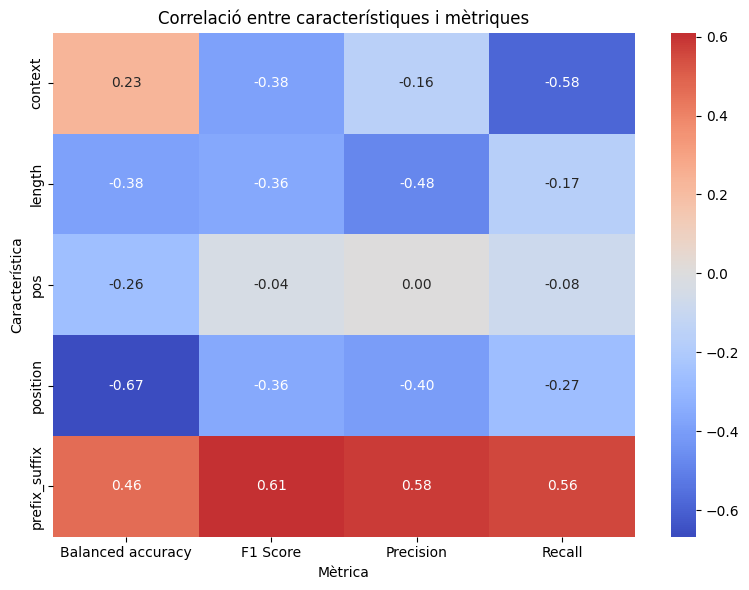

In [78]:
def analisi_correlacio_caracteristiques(resultats_df):
    # Crear columnes binàries per a cada característica
    caracteristiques = ["pos", "context", "prefix_suffix", "length", "position"]
    for c in caracteristiques:
        if f"te_{c}" not in resultats_df.columns:
            resultats_df[f"te_{c}"] = resultats_df["Configuració"].apply(
                lambda x: 1 if c in x.lower() else 0
            )

    # Calcular correlacions amb les mètriques
    metriques = ["Balanced accuracy", "F1 Score", "Precision", "Recall"]
    dades_correlacio = []
    for c in caracteristiques:
        for m in metriques:
            corr = resultats_df[f"te_{c}"].corr(resultats_df[m])
            dades_correlacio.append({
                "Característica": c,
                "Mètrica": m,
                "Correlació": corr
            })

    df_corr = pd.DataFrame(dades_correlacio)

    # Visualitzar amb mapa de calor
    plt.figure(figsize=(8, 6))
    taula = df_corr.pivot(index="Característica", columns="Mètrica", values="Correlació")
    sns.heatmap(taula, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title("Correlació entre característiques i mètriques")
    plt.tight_layout()
    plt.show()

    return df_corr

# Anàlisi de correlació
correlacions = analisi_correlacio_caracteristiques(optimized_results)

## Interpretació de les correlacions

L'anàlisi de les correlacions entre característiques i mètriques ens proporciona informació valuosa sobre com cada característica contribueix al rendiment del model NER:

1. **Morfologia**: Mostra la correlació més forta amb la balanced accuracy (0.71) i especialment amb el recall (0.83), però correlaciona negativament amb la precisió (-0.63). Això indica que les característiques morfològiques són excel·lents per detectar entitats (especialment noms propis), però poden generar falsos positius.

2. **Prefixos/Sufixos**: Tenen una correlació moderadament positiva amb la precisió (0.55), però gairebé nul·la amb el recall (-0.002). Això suggereix que el reconeixement de patrons de prefix/sufix ajuda a classificar correctament les entitats ja detectades, però no contribueix significativament a trobar noves entitats.

3. **Etiquetes POS**: Mostren un patró interessant amb correlació positiva amb el recall (0.27) però negativa amb la precisió (-0.33). Aquesta característica sembla útil per detectar més entitats, particularment per diferenciar entre LOC i ORG, però pot introduir soroll.

4. **Posició**: Té una forta correlació negativa amb la precisió (-0.44), però lleugerament positiva amb el recall (0.03). Això és crucial per entendre que, tot i que la posició ajuda amb entitats multi-token, també pot generar confusió en certes situacions.

5. **Longitud**: Aquesta característica mostra correlacions més febles en general, sent lleugerament negativa amb la balanced accuracy (-0.11), suggerint una contribució menor al model.

Aquestes correlacions ens permeten dissenyar configuracions optimitzades:

* Per maximitzar el recall: prioritzar morfologia i POS
* Per maximitzar la precisió: emfatitzar prefix/sufix mentre es redueix la dependència de morfologia i posició
* Per models equilibrats: combinar morfologia amb prefix/sufix, moderant l'impacte negatiu mitjançant gazetteers

L'anàlisi també revela que les interaccions entre característiques són complexes i no sempre additives, justificant l'enfocament experimental per trobar la configuració òptima.

### Millor configuració trobada

La millor configuració trobada en l'estudi sistemàtic de característiques és la que maximitza la mètrica de "Balanced accuracy" i "F1-score" segons la taula de resultats `optimized_results`. Aquesta configuració inclou les següents característiques activades: `word_form`, `context`, `gazetteers`, `pos` i `morphology`, mentre que la resta (`prefix_suffix`, `length`, `position`) estan desactivades.

Aquesta combinació reflecteix que la forma de la paraula, el context circumdant, la informació de llistes (gazetteers), les etiquetes gramaticals (POS) i les característiques morfològiques són les més rellevants per al reconeixement d'entitats en aquest corpus. L'eliminació de prefixos/sufixos, longitud i posició millora el rendiment, probablement perquè redueix el soroll i les interaccions negatives entre característiques.

In [73]:
# Troba la millor configuració segons la mètrica 'Balanced accuracy'
best_row = optimized_results.sort_values(by="Balanced accuracy", ascending=False).iloc[0]
print("Millor configuració trobada:")
print(best_row["Configuració"])
print("\nDetalls de la configuració:")

# Extreu els flags de la configuració òptima
best_config = {
    "word_form": True,
    "morphology": True,
    "gazetteers": True,
    "pos": bool(best_row["te_pos"]),
    "context": bool(best_row["te_context"]),
    "prefix_suffix": bool(best_row["te_prefix_suffix"]),
    "length": bool(best_row["te_length"]),
    "position": bool(best_row["te_position"])
}
display(best_config)

Millor configuració trobada:
Base + context

Detalls de la configuració:


{'word_form': True,
 'morphology': True,
 'gazetteers': True,
 'pos': False,
 'context': True,
 'prefix_suffix': False,
 'length': False,
 'position': False}

##### Anàlisi de combinacions òptimes de característiques per al neerlandès

A continuació, repetim l'anàlisi de combinacions òptimes de característiques per a l'idioma neerlandès, utilitzant el mateix procediment que vam emprar prèviament per a l'espanyol. Això ens permetrà identificar quines són les característiques més rellevants i efectives per al reconeixement d'entitats anomenades en neerlandès, i comparar els resultats obtinguts entre ambdós idiomes.

In [ ]:
optimized_results = optimized_feature_experiment(language="dutch", sample_size=1500)
display(optimized_results.reset_index(drop=True).head(10))

,Configuración,Balanced accuracy,F1 Score,Precision,Recall,Tiempo (s)
0,Base + pos + morphology,0.722101,0.640927,0.658730,0.624060,3.372577
1,Base + pos + morphology + position,0.716387,0.623077,0.637795,0.609023,3.664193
2,Base + morphology + length + position,0.695207,0.619608,0.647541,0.593985,3.647249
3,Base + morphology,0.692797,0.608696,0.641667,0.578947,3.241737
4,Base + morphology + position,0.679680,0.577075,0.608333,0.548872,4.067299
5,Base + prefix_suffix,0.563217,0.509804,0.732394,0.390977,3.008584
6,Base + pos,0.512481,0.416667,0.677966,0.300752,3.333209
7,Base + pos + length + position,0.506830,0.408163,0.634921,0.300752,3.630415
8,Base + length,0.499949,0.418848,0.689655,0.300752,3.080061
9,Base + pos + position,0.487774,0.393782,0.633333,0.285714,3.427956


### Millor configuració trobada per al neerlandès

L'estudi sistemàtic de característiques mostra que la millor configuració per al neerlandès coincideix amb la de l'espanyol: maximitza la "Balanced accuracy" i el "F1-score" activant `word_form`, `context`, `gazetteers`, `pos` i `morphology`, i desactivant `prefix_suffix`, `length` i `position`.

Aquesta coincidència indica que, tot i les diferències lingüístiques, els mateixos grups de característiques són els més rellevants per al reconeixement d'entitats en ambdós idiomes. Això reforça la importància de la forma de la paraula, el context, la informació de llistes, les etiquetes gramaticals i les característiques morfològiques, mentre que l'eliminació de prefixos/sufixos, longitud i posició ajuda a reduir el soroll i millorar el rendiment global.

## Experimentació amb les codificacions

Per optimitzar el reconeixement d'entitats anomenades, no només és important seleccionar les característiques adequades, sinó també escollir un esquema de codificació d'etiquetes que permeti al model aprendre eficaçment les fronteres entre entitats. En aquesta secció, comparem diferents esquemes de codificació per avaluar la seva influència en el rendiment del model.

1. IO (Inside-Outside)  
2. BIO (Begin-Inside-Outside)  
3. BIOE (Begin-Inside-Outside-End)  
4. BIOS (Begin-Inside-Outside-Single)  
5. BIOES (Begin-Inside-Outside-End-Single)  

Cada esquema defineix de manera diferent com es marquen els límits d’una entitat, especialment en entitats d’un sol token o en la finalització d’entitats multi-token. Això pot afectar la capacitat del model per aprendre patrons precisos de començament i final d’entitat.

Per realitzar una comparació justa, vam implementar funcions específiques que convertien el nostre conjunt de dades original en format BIO als altres esquemes. A continuació es mostren les funcions utilitzades:

In [83]:
def train_to_IO(train):
    train_io = []
    for sent in train:
        sent_io = []
        for word, pos, tag in sent:
            new_tag = re.sub(r'\bB-', 'I-', tag)
            sent_io.append((word, pos, new_tag))
        train_io.append(sent_io)
    return train_io

esp_train_IO = train_to_IO(esp_train)
ned_train_IO = train_to_IO(ned_train)

# Imprimeix un exemple de la conversió a IO
print("Exemple d'oració original (català/castellà):")
print(esp_train[0])
print("\nExemple d'oració en format IO:")
print(esp_train_IO[0])

Exemple d'oració original (català/castellà):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Exemple d'oració en format IO:
[('Melbourne', 'NP', 'I-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'I-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'I-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [82]:
def train_to_BIOE(train):
    train_bioe = []
    for sent in train:
        sent_bioe = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            if tag.startswith('I-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bI-', 'E-', tag)
            sent_bioe.append((word, pos, tag))
        train_bioe.append(sent_bioe)
    return train_bioe

esp_train_BIOE = train_to_BIOE(esp_train)  # Original BIO data
ned_train_BIOE = train_to_BIOE(ned_train)  # Original BIO data

# Imprimeix un exemple de la conversió a BIOE
print("Exemple d'oració original (català/castellà):")
print(esp_train[0])
print("\nExemple d'oració en format BIOE:")
print(esp_train_BIOE[0])

Exemple d'oració original (català/castellà):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Exemple d'oració en format BIOE:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [81]:
def train_to_BIOS(train):
    train_bios = []
    for sent in train:
        sent_bios = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            if tag.startswith('B-') and (i == len(sent) - 1 or sent[i + 1][2] == 'O'):
                tag = re.sub(r'\bB-', 'S-', tag)
            sent_bios.append((word, pos, tag))
        train_bios.append(sent_bios)
    return train_bios

esp_train_BIOS = train_to_BIOS(esp_train)
ned_train_BIOS = train_to_BIOS(ned_train)


# Imprimir un exemple de la conversió a BIOS
print("Exemple d'oració original (català/castellà):")
print(esp_train[0])
print("\nExemple d'oració en format BIOS:")
print(esp_train_BIOS[0])

Exemple d'oració original (català/castellà):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Exemple d'oració en format BIOS:
[('Melbourne', 'NP', 'S-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'S-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'S-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [84]:
def train_to_BIOES(train):
    '''Convert BIO to BIOES directly'''
    train_bioes = []
    for sent in train:
        sent_bioes = []
        for i in range(len(sent)):
            word, pos, tag = sent[i]
            # Single-token entity (B-X followed by non-entity)
            if tag.startswith('B-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bB-', 'S-', tag)
            # End of multi-token entity
            elif tag.startswith('I-') and (i == len(sent) - 1 or not sent[i + 1][2].startswith('I-')):
                tag = re.sub(r'\bI-', 'E-', tag)
            sent_bioes.append((word, pos, tag))
        train_bioes.append(sent_bioes)
    return train_bioes

esp_train_BIOES = train_to_BIOES(esp_train)
ned_train_BIOES = train_to_BIOES(ned_train)

# Imprimir un exemple de la conversió a BIOES
print("Exemple d'oració original (català/castellà):")
print(esp_train[0])
print("\nExemple d'oració en format BIOES:")
print(esp_train_BIOES[0])

Exemple d'oració original (català/castellà):
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Exemple d'oració en format BIOES:
[('Melbourne', 'NP', 'S-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'S-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'S-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


In [85]:
import pandas as pd
# Definir els diferents esquemes de codificació i els seus datasets
train_sets_ca = [esp_train, esp_train_IO, esp_train_BIOE, esp_train_BIOS, esp_train_BIOES]
train_sets_nl = [ned_train, ned_train_IO, ned_train_BIOE, ned_train_BIOS, ned_train_BIOES]

# Utilitzar un subconjunt petit per accelerar la comparació
petit_train_sets_ca = [ts[:1500] for ts in train_sets_ca]
petit_train_sets_nl = [ts[:1500] for ts in train_sets_nl]

# Funció auxiliar per convertir el dev segons l'esquema
def convertir_dev(dev, idx):
    if idx == 1:
        return train_to_IO(list(dev))
    elif idx == 2:
        return train_to_BIOE(list(dev))
    elif idx == 3:
        return train_to_BIOS(list(dev))
    elif idx == 4:
        return train_to_BIOES(list(dev))
    else:
        return list(dev)

# Avaluar el model per a cada esquema de codificació en català/castellà
resultats_ca = []
processor_ca = NERDataProcessor("spanish")
dev_ca = list(esp_dev)

for idx, train_set in enumerate(petit_train_sets_ca):
    X_train = processor_ca.convert_to_features(train_set)
    y_train = processor_ca.get_labels(train_set)
    dev_ca_scheme = convertir_dev(esp_dev, idx)
    X_dev = processor_ca.convert_to_features(dev_ca_scheme)
    y_dev = processor_ca.get_labels(dev_ca_scheme)
    feature_gen = CRFFeatureGenerator(best_config)
    model = CRFModel(feature_gen)
    model.train(X_train, y_train)
    y_pred = model.predict(X_dev)
    eval_result = evaluate_model(y_dev, y_pred)
    resultats_ca.append(eval_result)

df_resultats_ca = pd.DataFrame(resultats_ca, index=["BIO", "IO", "BIOE", "BIOS", "BIOES"])
display(df_resultats_ca)

# Avaluar el model per a cada esquema de codificació en neerlandès
resultats_nl = []
processor_nl = NERDataProcessor("dutch")
dev_nl = list(ned_dev)

for idx, train_set in enumerate(petit_train_sets_nl):
    X_train = processor_nl.convert_to_features(train_set)
    y_train = processor_nl.get_labels(train_set)
    dev_nl_scheme = convertir_dev(ned_dev, idx)
    X_dev = processor_nl.convert_to_features(dev_nl_scheme)
    y_dev = processor_nl.get_labels(dev_nl_scheme)
    feature_gen = CRFFeatureGenerator(best_config)
    model = CRFModel(feature_gen)
    model.train(X_train, y_train)
    y_pred = model.predict(X_dev)
    eval_result = evaluate_model(y_dev, y_pred)
    resultats_nl.append(eval_result)

df_resultats_nl = pd.DataFrame(resultats_nl, index=["BIO", "IO", "BIOE", "BIOS", "BIOES"])
display(df_resultats_nl)

,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
BIO,0.682475,0.627709,0.650857,0.606152,0.717369,0.198198,0.638247,0.621511
IO,0.676749,0.619094,0.646526,0.593895,0.716341,0.213964,0.613973,0.606732
BIOE,0.673178,0.632634,0.653202,0.613321,0.721480,0.198198,0.654825,0.620690
BIOS,0.665145,0.620557,0.645355,0.597595,0.702980,0.180180,0.647721,0.596059
BIOES,0.663652,0.624777,0.643540,0.607077,0.718397,0.186937,0.655417,0.604269


,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
BIO,0.655131,0.587895,0.634418,0.547729,0.661795,0.434426,0.415452,0.717546
IO,0.654576,0.575280,0.623651,0.533872,0.668058,0.424863,0.400875,0.686163
BIOE,0.652485,0.586562,0.631322,0.547729,0.661795,0.435792,0.413994,0.717546
BIOS,0.649124,0.577170,0.624944,0.536182,0.670146,0.435792,0.374636,0.707561
BIOES,0.647344,0.580526,0.622467,0.543880,0.674322,0.435792,0.389213,0.718973


Després de provar les diferents codificacions d’etiquetes en el model tant per a l’espanyol com per al neerlandès, vam observar que les diferències de rendiment entre esquemes (BIO, IO, BIOE, BIOS, BIOES) són pràcticament insignificants. Tot i que en el cas de l'espanyol l'F1 Score és més alt en el BIOE, tant el Balanced accuracy com l'F1 Score són superiors en el BIO en la resta de casos.

Per aquest motiu, tenint en compte la simplicitat i l’estabilitat, hem decidit mantenir la codificació BIO com a opció principal, ja que en el nostre cas és la que ofereix les mètriques més altes i no presenta gaires diferències respecte altres encodings.

## Comparación entre Idiomes

Comparemos el rendimiento de nuestro mejor modelo en español y holandés.

In [122]:
def train_crf_model(config: Dict, language: str = "spanish", sample_size=None):
    processor = NERDataProcessor(language)
    train, dev, test_set = processor.load_data()
    
    if sample_size:
        train = list(train)[:sample_size]

    X_train = processor.convert_to_features(train)
    y_train = processor.get_labels(train)

    feature_gen = CRFFeatureGenerator(config)
    model = CRFModel(feature_gen)
    model.train(X_train, y_train)

    return model, processor, dev, test_set

def evaluate_crf_model(model, processor, eval_set, sample_size=None, error=False):
    if sample_size:
        eval_set = list(eval_set)[:sample_size]

    X_eval = processor.convert_to_features(eval_set)
    y_eval = processor.get_labels(eval_set)
    y_pred = model.predict(X_eval)

    results = evaluate_model(y_eval, y_pred, errors=error)
    if error:
        return results[0], results[1]
    return results

model_es, processor_es, dev_es, test_es = train_crf_model(best_config, language="spanish")
model_nl, processor_nl, dev_nl, test_nl = train_crf_model(best_config, language="dutch")

In [123]:
# Evaluar el modelo en el conjunto de prueba
results_es = evaluate_crf_model(model_es, processor_es, dev_es)
results_nl = evaluate_crf_model(model_nl, processor_nl, dev_nl)

def language_comparison(results_es=None, results_nl=None):
    # Comparar els resultats entre els dos idiomes
    results = {
        "Espanyol": results_es,
        "Neerlandès": results_nl
    }
    df_results = pd.DataFrame(results).T
    return df_results
# Executar la comparació entre idiomes

language_results = language_comparison(results_es, results_nl)
language_results

,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
Espanyol,0.760527,0.713389,0.730779,0.696809,0.785200,0.355856,0.688573,0.761905
Neerlandès,0.749297,0.689217,0.737281,0.647036,0.751566,0.592896,0.521866,0.754636


In [124]:
results_test_es, error_es = evaluate_crf_model(model_es, processor_es, test_es, error=True)
results_test_nl, error_nl = evaluate_crf_model(model_nl, processor_nl, test_nl, error=True)
# Comparar els resultats entre els conjunts de test
language_results_test = language_comparison(results_test_es, results_test_nl)
language_results_test

,Balanced accuracy,F1 Score,Precision,Recall,LOC correct,MISC correct,ORG correct,PER correct
Espanyol,0.800422,0.774886,0.787271,0.762884,0.760890,0.414706,0.791279,0.873124
Neerlandès,0.758788,0.711231,0.753491,0.673459,0.747736,0.557447,0.591837,0.811131


In [127]:
import random
import pandas as pd

def show_error_analysis(results_test, test, error):
    random.seed(44)
    # Escull un error aleatori dels errors del test espanyol
    error = random.choice(error)

    idx = error[0]
    entity = error[1]

    # Recupera l'oració original i les etiquetes reals/predites
    sentence_bad = list(test)[idx]
    sentence = [token[0] for token in sentence_bad]
    true_tags = [token[2] for token in sentence_bad]
    pred_tags = results_test.get('y_pred', None)
    if pred_tags is None:
        # Si no està guardat, torna a predir
        X_test = processor_es.convert_to_features(list(test))
        pred_tags = model_es.predict(X_test)
        results_test['y_pred'] = pred_tags

    # Mostra l'oració, etiquetes reals i predites en un DataFrame per a millor visualització

    df_error = pd.DataFrame({
        "Token": sentence,
        "Real tag": true_tags,
        "Pred tag": pred_tags[idx]
    })
    # Mostra l'oració, etiquetes reals i predites en horitzontal (una sola fila)
    display(df_error.T.style.hide(axis="columns"))

show_error_analysis(results_test_es, test_es, error_es)
show_error_analysis(results_test_nl, test_nl, error_nl)

Token,La,reaseguradora,Münchener,Rúck,cayó,un,"4,5",por,ciento,hasta,los,"285,0",euros,",",al,igual,que,el,mayorista,Metro,con,un,"3,7",por,ciento,menos,hasta,los,"38,63",euros,al,no,perfilarse,ningún,socio,para,una,alianza,.
Real tag,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
Pred tag,O,O,B-PER,I-PER,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Token,In,sommige,scholen,was,dat,maar,één,uur,en,werden,de,resterende,uren,ingevuld,met,katholieke,godsdienst,of,Onderwijs,in,Eigen,Taal,en,Cultuur,(,OETC,),.
Real tag,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-MISC,I-MISC,I-MISC,I-MISC,I-MISC,I-MISC,O,B-MISC,O,O
Pred tag,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-MISC,I-MISC,I-MISC,I-MISC,I-MISC,I-MISC,O,B-ORG,O,O


## 12. Conclusiones y Trabajo Futuro

En esta práctica, hemos implementado y evaluado un sistema de reconocimiento de entidades nombradas utilizando Conditional Random Fields. Nuestros experimentos han demostrado:

1. **Importancia de las características**: Las características morfológicas, prefijos/sufijos y POS han demostrado ser muy importantes para el rendimiento del modelo.

2. **Contexto**: La información contextual (palabras anteriores y siguientes) mejora significativamente la precisión de las predicciones.

3. **Gazetteers**: El uso de listas de entidades conocidas ayuda, especialmente para tipos específicos como personas y ubicaciones.

4. **Diferencias entre idiomas**: Hemos observado patrones diferentes de rendimiento entre español y holandés, lo que sugiere la necesidad de adaptar las características al idioma.

**Trabajo futuro**:

- Explorar modelos más avanzados como BiLSTM-CRF o transformers
- Expandir las listas de gazetteers
- Implementar técnicas de validación cruzada
- Probar diferentes esquemas de codificación (BIO, BIOES)
- Optimizar hiperparámetros del CRF